<a href="https://colab.research.google.com/github/evauclin/Deep_Learning_NLP_Project/blob/main/NLP_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')



In [5]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/train.csv').drop(['id','keyword','location'],axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/test.csv').drop(['id','keyword','location'],axis=1)
test.head()


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 532 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [8]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
# Remove all non alphanumeric characters except whitespaces
train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
train.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


In [11]:
X = train.text_clean
X

0                    deed reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4       send photo ruby alaska smoke wildfire pour school
                              ...                        
7608    giant crane hold bridge collapse nearby home h...
7609    ariaahrary thetawniest control wild fire calif...
7610    m194 0104 utc5 km s volcano hawaii httptcozdto...
7611    police investigate ebike collide car little po...
7612    late home raze northern california wildfire   ...
Name: text_clean, Length: 7613, dtype: object

In [12]:
y = train.target
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y , test_size=0.4,stratify=y)

In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.32,stratify=y_val_test)

In [15]:
train_data = pd.concat([X_train,y_train],axis = 1)

In [16]:
val_data = pd.concat([X_val,y_val],axis = 1)

In [17]:
test_data = pd.concat([X_test,y_test],axis = 1)

In [18]:
train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

In [21]:
preprocess_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [22]:
bert_preprocess_model = hub.KerasLayer(preprocess_model)


In [23]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [25]:
bert_model = hub.KerasLayer(bert_model)

In [26]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f3ce45010d0>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.9216989  -0.39353472 -0.5393176   0.682563    0.43848526 -0.14021198
  0.8774715   0.26043355 -0.63113034 -0.9999658  -0.26320082  0.8510534 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451515  0.25141722  0.19075063 ... -0.24845128  0.38568568
   0.1329099 ]
 [-0.5947862  -0.39420295  0.25245643 ... -0.769468    1.1564158
   0.32475588]
 [ 0.00641477 -0.15766507  0.5461029  ... -0.17451143  0.60289675
   0.42672214]
 ...
 [ 0.21948312 -0.20927148  0.5386829  ...  0.24693674  0.18250933
  -0.4442711 ]
 [ 0.01080263 -0.44553217  0.35990965 ...  0.31722867  0.2356279
  -0.63070595]
 [ 0.29321143 -0.10581905  0.61147535 ...  0.2074582   0.14494652
  -0.35353374]]


In [27]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [28]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6304638]], shape=(1, 1), dtype=float32)


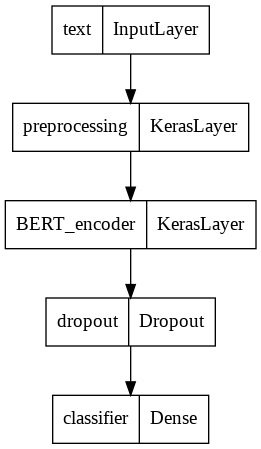

In [29]:
tf.keras.utils.plot_model(classifier_model)

In [30]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [31]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [32]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [33]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [34]:
print('Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/2
143/143 [==============================] - 293s 2s/step - loss: 0.5199 - binary_accuracy: 0.7331 - val_loss: 0.4342 - val_binary_accuracy: 0.8300
Epoch 2/2
143/143 [==============================] - 274s 2s/step - loss: 0.3641 - binary_accuracy: 0.8515 - val_loss: 0.4576 - val_binary_accuracy: 0.8291


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


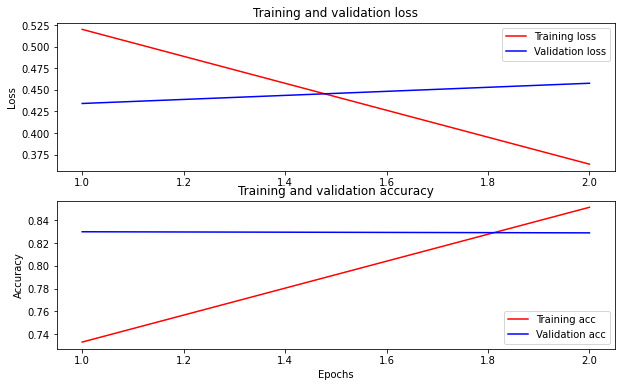

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [44]:
test = list(test_data.iloc[:,0])
test

['leicestermerc   icymi   ashe 2015 australia collapse trent bridge   twitter reaû httptcohqewmreyso httptcoy4y8fcljed',
 'man kill crash barrington hills hoffman estate man kill singlecar crash wednesday afte httptcob6nphxorzg',
 'apply muslimsterrorismor catholicismhomophobia',
 'practice family fire escape plan know case emergency',
 'sign amp rt save saltriverwildhorse httptcoikuayuseqt httptcobqbhuyfme9',
 'savannahross4 tryna ruin life',
 'dad buy dvd look like science doc read actually impending biblical apocalypse',
 'want fuck duck explode greasy',
 'come land engulf tribal war turn land peace ie madinah prophetmuhammad islam',
 'think run choice life rembr s kid choice wear suicide bomb vest',
 'eyewitness media actively embrace uk audience read report emhub impact ugc news httptco6mbpvwitxf',
 'ûïsplottdave teampalestina s 28700 palestinian home demolish israel 1967 w 0 israeli home demolish potu',
 'carlachamorros hillary mass murderer',
 'greedy bastard fullscreen way ruin

In [37]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


# reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(test)))

# print('Results from the saved model:')
# print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(test, original_results)

Results from the model in memory:
input: leicestermerc   icymi   ashe 2015 australia collapse trent bridge   twitter reaû httptcohqewmreyso httptcoy4y8fcljed : score: 0.969518
input: man kill crash barrington hills hoffman estate man kill singlecar crash wednesday afte httptcob6nphxorzg : score: 0.987921
input: apply muslimsterrorismor catholicismhomophobia : score: 0.399904
input: practice family fire escape plan know case emergency : score: 0.587785
input: sign amp rt save saltriverwildhorse httptcoikuayuseqt httptcobqbhuyfme9 : score: 0.062020
input: savannahross4 tryna ruin life  : score: 0.054811
input: dad buy dvd look like science doc read actually impending biblical apocalypse : score: 0.096430
input: want fuck duck explode greasy  : score: 0.051047
input: come land engulf tribal war turn land peace ie madinah prophetmuhammad islam : score: 0.303900
input: think run choice life rembr s kid choice wear suicide bomb vest : score: 0.149288
input: eyewitness media actively embrace 

In [38]:
_tensor = tf.make_tensor_proto(tf.constant(original_results))

In [39]:
tensor = tf.make_ndarray(_tensor)

In [40]:
mapping = lambda x : 0 if x<0.5 else 1
vfunc = np.vectorize(mapping)
vfunc(tensor)
array_pred = np.resize(vfunc(tensor),(len(vfunc(tensor))))
array_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [41]:
array_true = np.array(test_data.target)
array_true

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [42]:
precision = precision_score(array_true, array_pred)
print('Precision: %f' % precision)
recall = recall_score(array_true, array_pred)
print('Recall: %f' % recall)
f1 = f1_score(array_true, array_pred)
print('F1 score: %f' % f1)
auc = roc_auc_score(array_true, array_pred)
print('ROC AUC: %f' % auc)



Precision: 0.788095
Recall: 0.789976
F1 score: 0.789035
ROC AUC: 0.814952


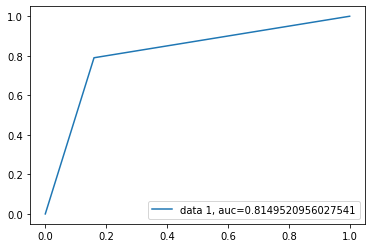

In [43]:
fpr, tpr, _ = roc_curve(array_true, array_pred)
auc = roc_auc_score(array_true, array_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()